In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [10]:
#Taking a look in the data
row1m = session.query(measurement).first()
row1m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1186d8610>,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
row1s = session.query(station).first()
row1s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1186e4050>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# 1.- Calculate the date 1 year ago from the last data point in the database
# Here I take a look on data composition first, last and total records
print ( f' first date : {session.query(measurement.date).order_by(measurement.date).first()}, last date : {session.query(measurement.date).order_by(measurement.date.desc()).first()}, total dates : {session.query(func.count(measurement.date)).all()}' )

first date : ('2010-01-01',), last date : ('2017-08-23',), total dates : [(19550,)]


In [13]:
# The last date is 2017-08-23 so a year after we are looking for is 2016-08-23
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"Last 12 months start at {last_12_months}")

Last 12 months start at 2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
points = [measurement.date, measurement.prcp, measurement.station ]
last_12_months_data = session.query(*points).filter(measurement.date > f'{last_12_months}').order_by(measurement.date)
#Printing one result
last_12_months_data[0]

('2016-08-24', 0.08, 'USC00519397')

In [15]:
# Save the query results as a Pandas DataFrame 
data = pd.DataFrame(last_12_months_data)
#and set the index to the date column
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()


,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00513117
2016-08-24,2.28,USC00514830
2016-08-24,NaN,USC00517948
2016-08-24,1.22,USC00519523


In [16]:
# Sort the dataframe by date
data.sort_index()
data.head()

,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00513117
2016-08-24,2.28,USC00514830
2016-08-24,NaN,USC00517948
2016-08-24,1.22,USC00519523


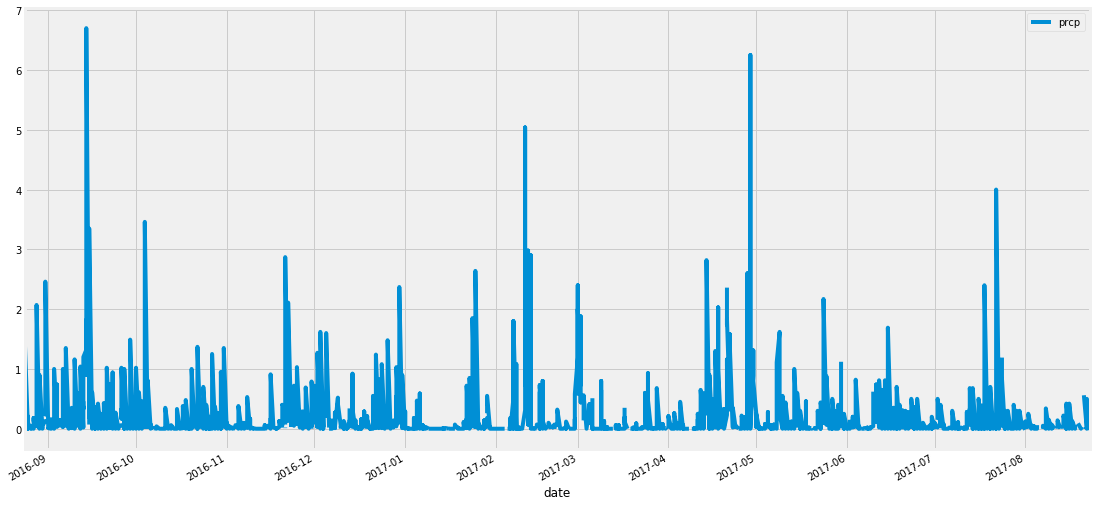

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
data.plot.line(figsize=(17,9))

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(measurement.station).group_by(measurement.station).count()
print(f"There are {stations_count} stations in this dataset")


There are 9 stations in this dataset


In [20]:
from sqlalchemy import distinct
# What are the most active stations? (i.e. what stations have the most rows)?
stations = session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).order_by(func.count(measurement.date).desc())
# List the stations and the counts in descending order.
for x in stations:
    print(x)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
lowest_temp = session.query(measurement.tobs).filter(measurement.station == 'USC00519281').order_by(measurement.tobs.asc()).first()
print(f'The lowest temperature recorded from station USC00519281 was {round(lowest_temp[0])}')
# highest temperature recorded, 
highest_temp = session.query(measurement.tobs).filter(measurement.station == 'USC00519281').order_by(measurement.tobs.desc()).first()
print(f'The hightest temperature recorded from station USC00519281 was {round(highest_temp[0])}')
# and average temperature of the most active station?
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'The average recorded temperature from station USC00519281 was {round(avg_temp[0][0],2)}') 

The lowest temperature recorded from station USC00519281 was 54
The hightest temperature recorded from station USC00519281 was 85
The average recorded temperature from station USC00519281 was 71.66


In [22]:
# Choose the station with the highest number of temperature observations.
high_temp_station = session.query(func.max(measurement.tobs), measurement.station).all()
print(f'The station with the highest temperature record was {high_temp_station[0][1]}, who registered a temperature of {high_temp_station[0][0]}')


The station with the highest temperature record was USC00519397, who registered a temperature of 87.0


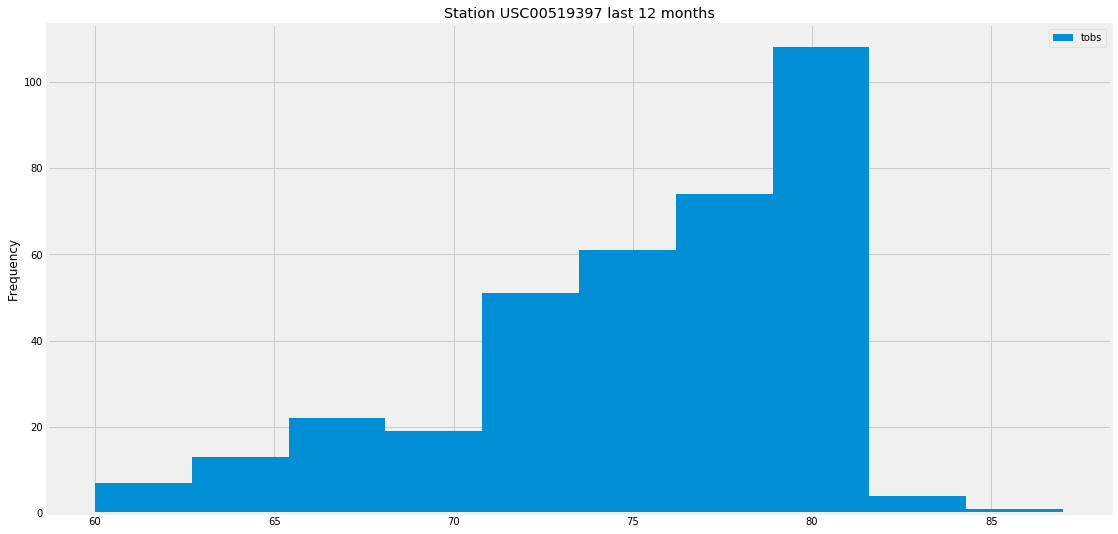

In [23]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from sqlalchemy import and_
months_station397 = session.query(measurement.date, measurement.tobs).filter(and_(measurement.station == "USC00519397", measurement.date > f'{last_12_months}')).order_by(measurement.date.desc()).all()
months_station397 = pd.DataFrame(months_station397)
months_station397.plot.hist(figsize=(17,9))
plt.title("Station USC00519397 last 12 months")
plt.show()


## Bonus Challenge Assignment

In [46]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return list(session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [165]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Here I create a for loop to itaret throw the dates and aply the function calc_temps, also appending year.
data_list = []
date_list = []
start_d = dt.date(2017, 7, 1)
end_d = dt.date(2017, 7, 16)
for x in range(1,9,1):
    data_list.append(calc_temps(start_d, end_d))
    date_list.append(end_d.year)
    start_d = dt.date(2018 - x, 7, 1) - dt.timedelta(days=365)
    end_d = dt.date(2018 - x, 7, 16) - dt.timedelta(days=365)

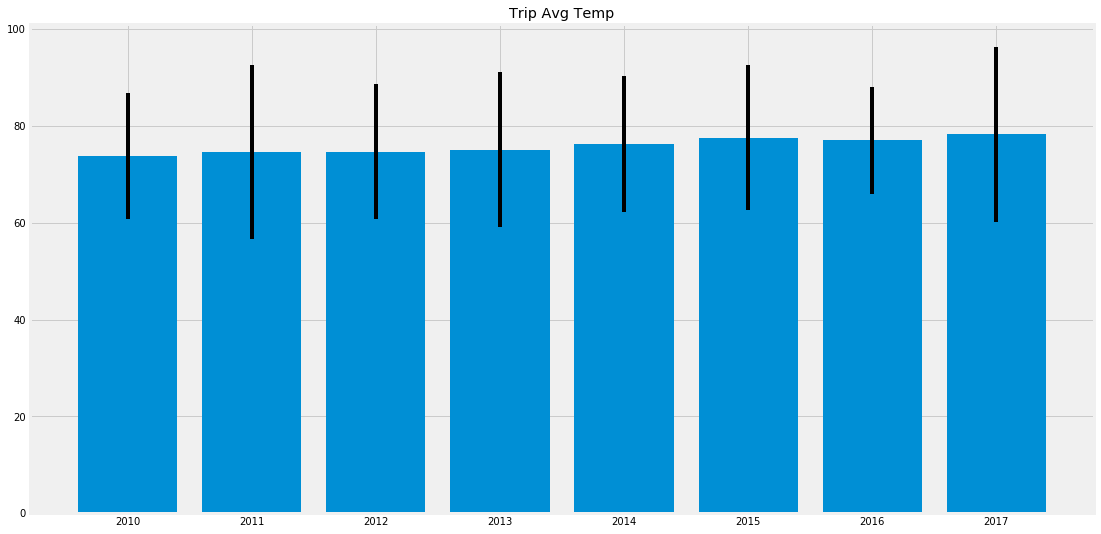

In [189]:
# Plot the results from your previous query as a bar chart. 
# Use the average temperature for the y value
    #I had to iterate through the given tuple to get independent values
y_values  = [x [0][1] for x in data_list ]
x_values = date_list
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
    #I had to iterate through the given tuple to get independent values 
tmax = [x [0][0] for x in data_list]
tmin = [x [0][2] for x in data_list]
    #So here I substract one list from another to get the asked peak list 
max_min = []
max_min.append(list(x - y for x, y in zip(tmin,tmax,)))

#Now we can start plotting
plt.figure(figsize=(17,9))
plt.bar(x_values, y_values, yerr=max_min[0])
# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')
plt.show()


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
